In [ ]:
#Series de tiempos
#Prediccion de temperaturas
  #https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53 
#Prediccion de series de spotify
  #https://medium.com/analytics-vidhya/time-series-analysis-using-arima-and-lstm-in-python-and-keras-part1-f987e11f9f8c

In [ ]:
#!pip install Flask

In [1]:
# importando modulos necesarios
import numpy as np
import pandas as pd
#import pandas.io.data as web
import datetime as dt
import datetime  
from pydataset import data
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pandas_datareader import data as web

# librerías de visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl


# graficos incrustados
%matplotlib inline

# pandas solo 4 decimales
pd.set_option('precision', 4)

# No muestra los warnings
import warnings
warnings.filterwarnings("ignore")

### Import para Prophet
from fbprophet import Prophet
import fbprophet

from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

### Import librería Pickle
import pickle

### Import librerías para Flask, las que vamos a necesitar para hacer los llamados y para lidiar con los datos en formato json
import requests
from flask import  Flask, request, jsonify, render_template
import json

In [2]:
# Iniciamos nuestra API
app = Flask('Analisis_Yahoo_Finance')

In [3]:
#Funcion para calcular en función a la empresa y el año que el usuario requiera, pronosticar los días deseados:
@app.route('/analizar_empresa', methods = ['POST'])
def analizar_empresa():
    tiempo_inicio = time.time()
    # la función "request.get_json" de Flask para capturar la información que le envíemos a la API
    data = request.get_json(force=True)
    
    # Separamos la información de data y usamos json.loads() para transformar el dataframe que está en formato
    # json a un diccionario y luego lo convertimos en un DataFrame.
    cod_empresa = data['empresa_elegida']
    fec_aaaa_mm_dd_inicio = data['fecha_inicio']
    fec_aaaa_mm_dd_fin = data['fecha_fin']

    df = web.DataReader(cod_empresa, 'yahoo', fec_aaaa_mm_dd_inicio, fec_aaaa_mm_dd_fin)
    
    ### Modelo SARIMA
    df_sarima = df.rename(columns={'Adj Close':'value'})
    df_sarima = df_sarima[['value']]
    qtrain = int(df_sarima.shape[0]*.80)
    qtest = df_sarima.shape[0] - qtrain
    fec_train = pd.DataFrame(df_sarima.iloc[qtrain,:]).columns[0].strftime('%F')
    print('Fecha train: ' + fec_train)
    print('qtrain: ' + str(qtrain)) 
    
    #Separamos en train y test
    df_train = df_sarima.iloc[:qtrain]
    df_test = df_sarima.iloc[-qtest:]
    dias_test = df_test.shape[0] - 1
    print('Data set: ' + '(' + str(df_sarima.shape[0]) + ',' + str(df_sarima.shape[1]) + ')')
    print('Train: ' + '(' + str(df_train.shape[0]) + ',' + str(df_train.shape[1]) + ')')
    print('Test: ' + '(' + str(df_test.shape[0]) + ',' + str(df_test.shape[1]) + ')')
    print('Días de testing: ' + str(dias_test))
    print(df.head())

    #Ploteamos la serie
    plt.figure(figsize=(16,5), dpi=100)
    plt.plot(df_sarima.index, df_sarima.value, color='tab:red')
    plt.gca().set(title='Acciones de la empresa ' + cod_empresa + ' del periodo ' + fec_aaaa_mm_dd_inicio + ' / ' + fec_aaaa_mm_dd_fin, xlabel='Fecha', ylabel='Acciones al cierre')
    plt.show()
    
    # Graficamos Train y Test
    fig, ax = plt.subplots(figsize=(20,7))
    df_train.plot(ax=ax, label='Train')
    df_test.plot(ax=ax, label='Test')
    ax.set_title('Train y Test')
    plt.show()
    
    # Preparamos los datos
    df_train['year'] = [d.year for d in df_train.index]
    df_train['month'] = [d.strftime('%b') for d in df_train.index]
    years = df_train['year'].unique()
    # Preparamos los colores:
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

    # Ploteamos
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='value', data=df_train, ax=axes[0])
    print(df.sample(15))
    sns.boxplot(x='month', y='value', data=df_train, ax=axes[1])
    #
    # Seteamos los títulos
    #
    axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
    axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);
    
    #Descomposición de Estacionalidad
    print('###')
    print(f'### Descompsición de Estacionalidad')
    print('###')
    decomposition = seasonal_decompose(df_train['value'], period=qtest)
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,10))
    decomposition.observed.plot(ax=ax1)
    decomposition.trend.plot(ax=ax2)
    decomposition.seasonal.plot(ax=ax3)
    decomposition.resid.plot(ax=ax4)
    decomposition.plot()
    plt.show()
    
    #Determinación de estadísticas móviles
    rolmean = pd.Series(df_train['value']).rolling(window=12).mean()
    #rolmean = pd.Series(df_train['value']).rolling(window=qtrain).mean()
    rolstd = pd.Series(df_train['value']).rolling(window=12).std()
    #rolstd = pd.Series(df_train['value']).rolling(window=qtrain).std()

    #Plot estadísticas móviles
    orig = plt.plot(df_train['value'], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media Móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviación Estándar')
    plt.legend(loc='best')
    plt.title('Media Móvil & Desviación Estándar')
    plt.show(block=False) 
    
    #Para verificar si una serie temporal es estacionaria o no, podemos:
    # realizar una inspección visual
    # realizar el Test de Dickey-Fuller aumentado (ojo sólo verifica que sea estacionaria en la tendencia).
    result = adfuller(df_train['value'])
    print('###')
    print(f'### Test de Dickey-Fuller aumentado sobre la serie original')
    print('###')
    display(result)
    print('')
        
    #Visualización de gráficos de comprobación de serie estacionaria (original)
    print('###')
    print(f'### Gráficos ACF y PACF para verificar la estacionaridad de la serie original (train)')
    print('###')
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
    ax1 = plot_acf(df_train['value'], lags=12, ax=ax1)
    ax2 = plot_pacf(df_train['value'], lags=12, ax=ax2)
    plt.show()
    
    df_diff = df_sarima.diff().dropna()
    result_diff = adfuller(df_diff)
    print('###')
    print(f'### Test de Dickey-Fuller aumentado sobre la serie diferencial')
    print('###')
    display(result_diff)
    print('')
    
    #Visualización de gráficos de comprobación de serie estacionaria (diferencial)
    print('###')
    print(f'### Gráficos ACF y PACF para verificar la estacionaridad de la serie diferencial (train)')
    print('###')
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
    ax1 = plot_acf(df_train['value'].diff().dropna(), lags=12, ax=ax1)
    ax2 = plot_pacf(df_train['value'].diff().dropna(), lags=12, ax=ax2)
    plt.show()   
        
    df_diff_diff = df_train['value'].diff().diff(12).dropna()
    result_diff_diff = adfuller(df_diff)
    print('###')
    print(f'### Test de Dickey-Fuller aumentado sobre la serie doble diferencial (Estacionalidad)')
    print('###')
    display(result_diff_diff)
    print('')
    
    #Visualización de gráficos de comprobación de serie estacionaria (diferencial-diferencial)
    print('###')
    print(f'### Gráficos ACF y PACF para verificar la estacionaridad de la serie doble diferencial - Estacionalidad (train)')
    print('###')
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
    ax1 = plot_acf(df_train['value'].diff().diff(12).dropna(), lags=12, ax=ax1)
    ax2 = plot_pacf(df_train['value'].diff().diff(12).dropna(), lags=12, ax=ax2)
    plt.show()     
    
    #Verificación visual de la estacionaridad
    print('###')
    print(f'### Ruido Blanco')
    print('###')    
    df_train['value'].diff().diff(12).dropna().plot()
    plt.show()
    
    #Verificación numérica de la estacionaridad
    result = adfuller(df_train['value'].diff().diff(12).dropna())
    display(result)
    result = pd.DataFrame(result)
    if result.iloc[0,0] < -3.4391:
        print('###')
        print('### La serie es estacionaria con error < 1%')
        print('###')
    elif result.iloc[0,0] < -2.8654:
        print('###')
        print('### La serie es estacionaria con error < 5%')
        print('###')
    elif result.iloc[0,0] < -2.5688:
        print('###')
        print('### La serie es estacionaria con error < 10%')
        print('###')
    else:
        print('###')
        print('### La serie es no estacionaria')
        print('###')
    print('')
    
    #Creación de modelo
    model = pm.auto_arima(df_train['value'],
                      seasonal=True, m=12,
                      d=1, D=1, 
                 	  max_p=3, max_q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)      
    print(model.summary())
    
    #Diagnóstico del modelo
    model.plot_diagnostics(figsize=(16, 8))
    diagnostics_sarima = 'Grafico_Diagnostics_SARIMA_' + cod_empresa +'.png'
    plt.savefig('Data/' + diagnostics_sarima, dpi = 150)
    plt.show()
    
    # Generación de predicciones
    dynamic_forecast = model.predict(n_periods=dias_test)
    
    # Get confidence intervals of predictions
    confidence_intervals = model.conf_int()

    # Selección lower and upper confidence limits
    lower_limits = (model.conf_int().T)[0]
    upper_limits = (model.conf_int().T)[1]

    # Get confidence intervals of predictions
    model.conf_int()
    
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

    # plot the train data
    plt.plot(df_train.index, df_train['value'], label='observed')

    # plot your mean forecast
    plt.plot(df_test.iloc[0:dias_test].index, dynamic_forecast, color='r', label='forecast')

    # plot the test data
    plt.plot(df_test.iloc[0:dias_test].index, df_test.iloc[0:dias_test], label='test')

    # set labels, legends and show plot
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    #Guardamos el gráfico en fomato .PNG    
    grafico_sarima = 'Grafico_SARIMA_' + cod_empresa +'.png'
    plt.savefig('Data/' + 'Grafico_SARIMA_' + cod_empresa +'.png',dpi=150)
    
    plt.show()

   
    #Serializamos el modelo SARIMA con Pickle
    modelo_sarima_serializado = 'model_sarima_' + cod_empresa + '.pkl'
    with open(modelo_sarima_serializado, 'wb') as f_sarima:
        pickle.dump(model, f_sarima)
    
    print('###')
    print('### Serializamos el modelo:' + modelo_sarima_serializado)
    print('###')
    
    ### Modelo PROPHET
    print('')
    print('###')
    print('### Modelo PROPHET')
    print('###')
    print('')
    df = web.DataReader(cod_empresa, 'yahoo', fec_aaaa_mm_dd_inicio,fec_aaaa_mm_dd_fin)# fec_train)
    df['Dates'] = pd.to_datetime(df.index)
    df = df[['Dates','Adj Close']]
    df.columns = ['ds','y']
    df_prophet = df
    print(df_prophet.shape)
    df_prophet.tail()
    
    df_prophet.info()
        
    # Fitting with default parameters
    pfizer_model = Prophet(seasonality_mode='additive',growth='linear', yearly_seasonality=True, daily_seasonality=True)
    pfizer_model.fit(df_prophet)
    
    # Para poder comparar con el modelo SARIMA consideramos el mismo periodo de test
    future= pfizer_model.make_future_dataframe(periods=qtest, freq='d')
    future.tail()
    
    # Predecimos los valores de test
    pfizer_model_data=pfizer_model.predict(future)
    pfizer_model_data.tail()
    
    
    forecast = pfizer_model.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    fig1 = pfizer_model.plot(forecast)
    
    fig= pfizer_model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), pfizer_model, forecast)

    #Comprobación del modelo aumentando el changepoint_prior_scale
    pfizer_model_2 = Prophet( n_changepoints=qtest, # this is optional 
                              yearly_seasonality=True, daily_seasonality=True,
                              changepoint_prior_scale=0.1)
    
    forecast = pfizer_model_2.fit(df).predict(future)
    fig= pfizer_model_2.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), pfizer_model_2, forecast)

    #Prophet proporcionará un diagrama de componentes que describe gráficamente el modelo que ha encajado
    pfizer_model_2.plot_components(forecast)
    
    #Aplicamos Cross Validation sobre el último modelo
    pfizer_cv_2 = cross_validation(pfizer_model_2, 
                         initial='100 days', 
                         period='180 days', 
                         horizon = '60 days')
    pfizer_cv_2.tail()
    
    print('###')
    print('### Métricas y Modelo PROPHET pronosticando a 60 días')
    print('### PROPHET proporcionará un diagrama de componentes que describe gráficamente el modelo fitteado.')
    print('###')
    print('')
    pfizer_p_2 = performance_metrics(pfizer_cv_2)
    print(pfizer_p_2.tail())
    
    #Serializamos el modelo PROPHET con Pickle
    modelo_prophet_serializado = 'model_prophet_' + cod_empresa + '.pkl'
    with open(modelo_prophet_serializado, 'wb') as f_prophet:
        pickle.dump(pfizer_p_2, f_prophet)
        
    #time.sleep(30)
    print('###')
    print('### Serializamos el modelo:' + modelo_prophet_serializado)
    print('###')
    
    #Guardamos el gráfico en fomato .JPG
    grafico_prophet = 'Grafico_PROPHET_' + cod_empresa +'.png'
    fig.savefig('Data/' + grafico_prophet, dpi = 150)    
    
        # Armamos el return con los datos descriptivos del equipo seleccionado que no están en el gráfico
    tiempo_ejecucion = time.time() - tiempo_inicio
    return {'Grafico_Diagonostics_SARIMA': diagnostics_sarima,
            'Grafico_SARIMA':grafico_sarima,
            'Modelo_SARIMA':modelo_sarima_serializado,
            'Grafico_PROPHET':grafico_prophet,
            'Modelo_PROPHET':modelo_prophet_serializado,
            'Tiempo_Ejecucion_seg':round(tiempo_ejecucion,2)}

 * Serving Flask app "Analisis_Yahoo_Finance" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


Fecha train: 2019-10-18
qtrain: 201
Data set: (252,1)
Train: (201,1)
Test: (51,1)
Días de testing: 50
             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2019-01-02  43.50  42.64  43.12  43.25  2.5076e+07    40.4771
2019-01-03  43.34  41.95  43.24  42.04  2.7043e+07    39.3446
2019-01-04  43.35  42.26  42.44  43.00  2.5755e+07    40.2431
2019-01-07  43.62  42.86  43.07  43.23  1.9920e+07    40.4583
2019-01-08  43.70  43.15  43.56  43.43  1.8669e+07    40.6455


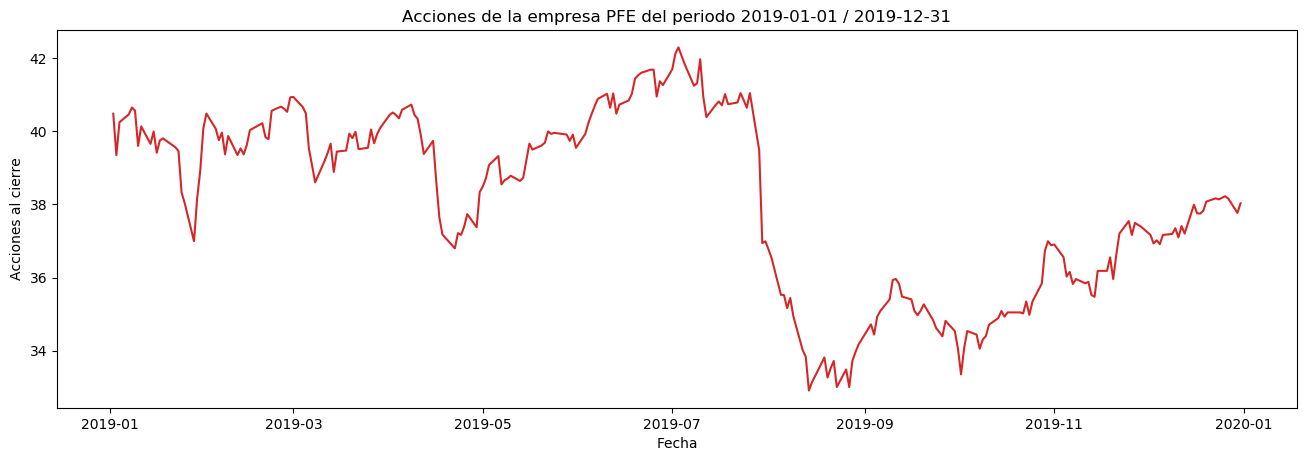

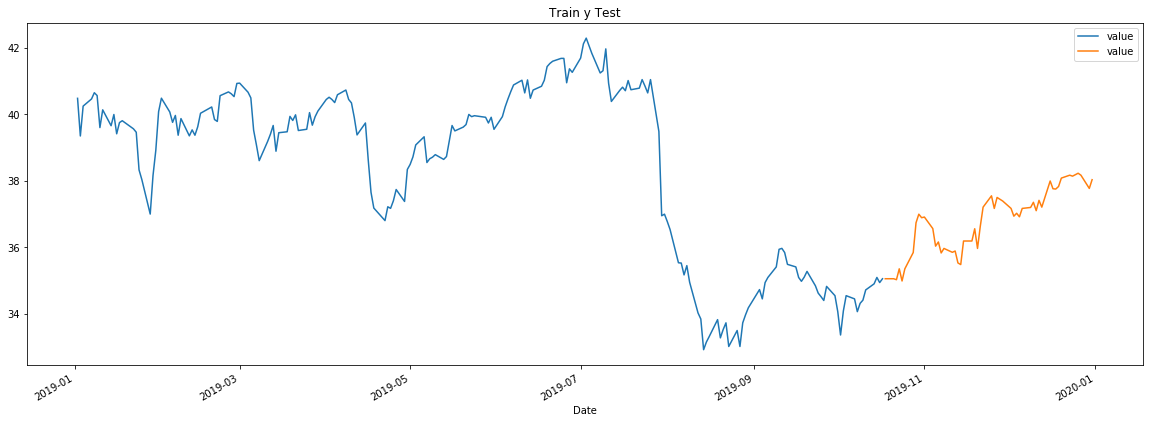

             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2019-04-30  41.18  39.80  40.40  40.61  3.2600e+07    38.3383
2019-02-26  43.23  42.80  42.96  43.02  1.5701e+07    40.6134
2019-10-08  35.88  35.42  35.65  35.43  1.4005e+07    34.0604
2019-06-06  43.09  42.48  42.80  42.71  2.3239e+07    40.6784
2019-03-20  42.40  41.78  42.20  42.17  2.2295e+07    39.8110
2019-09-11  37.76  36.90  37.74  37.41  1.6094e+07    35.9638
2019-05-13  40.65  40.15  40.23  40.57  2.6576e+07    38.6402
2019-12-03  38.20  37.84  37.96  38.05  1.9801e+07    36.9326
2019-04-24  39.64  39.16  39.50  39.37  2.0111e+07    37.1676
2019-01-29  40.85  39.47  39.50  40.77  4.8745e+07    38.1561
2019-12-23  39.52  39.13  39.42  39.32  1.6560e+07    38.1653
2019-04-05  43.28  42.89  42.98  42.99  1.4762e+07    40.5851
2019-09-18  36.72  36.26  36.57  36.38  1.8671e+07    34.9737
2019-01-31  42.62  41.35  41.38  42.45  3.8831e+07    40.0753
2019-01-

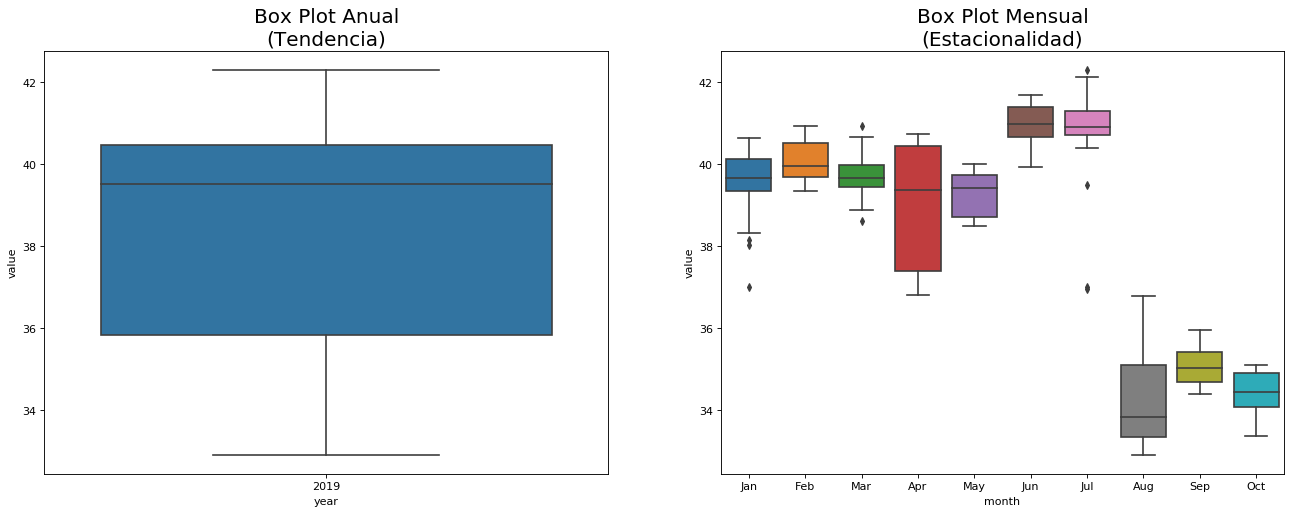

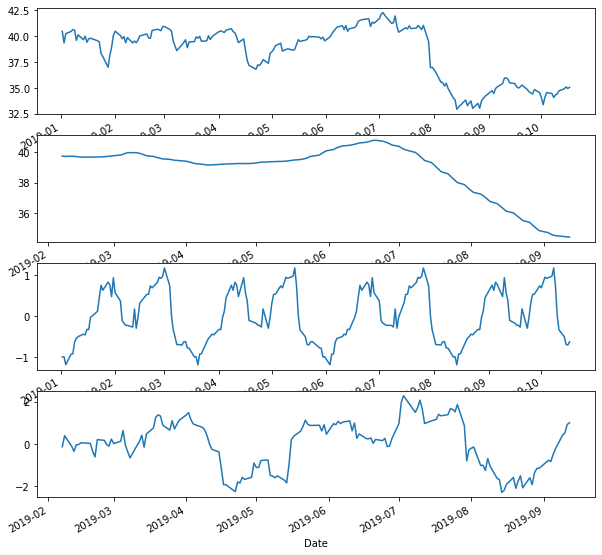

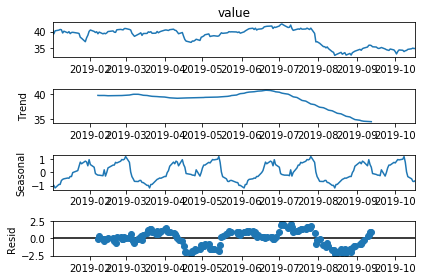

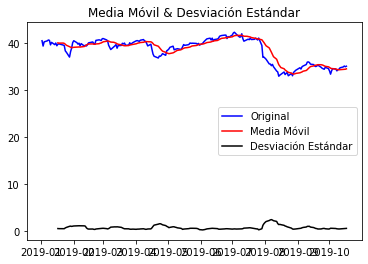

###
### Test de Dickey-Fuller aumentado sobre la serie original
###


(-1.0741505573040684,
 0.7252695286794686,
 1,
 199,
 {'1%': -3.4636447617687436,
  '5%': -2.8761761179270766,
  '10%': -2.57457158581854},
 248.78856890250188)


###
### Gráficos ACF y PACF para verificar la estacionaridad de la serie original (train)
###


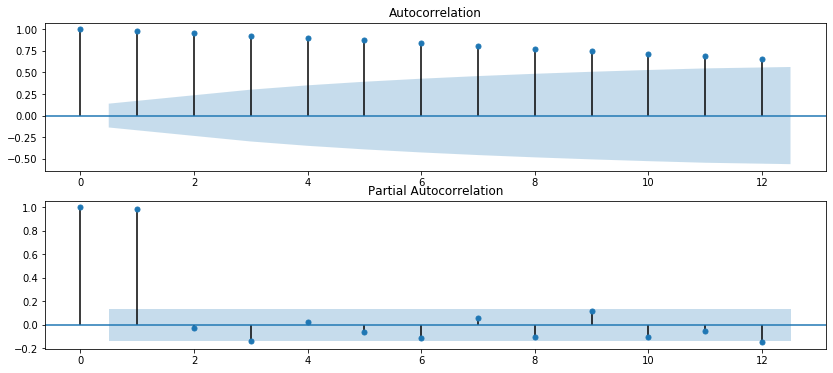

###
### Test de Dickey-Fuller aumentado sobre la serie diferencial
###


(-15.325164930646636,
 4.0145765250006756e-28,
 0,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 283.75391790266093)


###
### Gráficos ACF y PACF para verificar la estacionaridad de la serie diferencial (train)
###


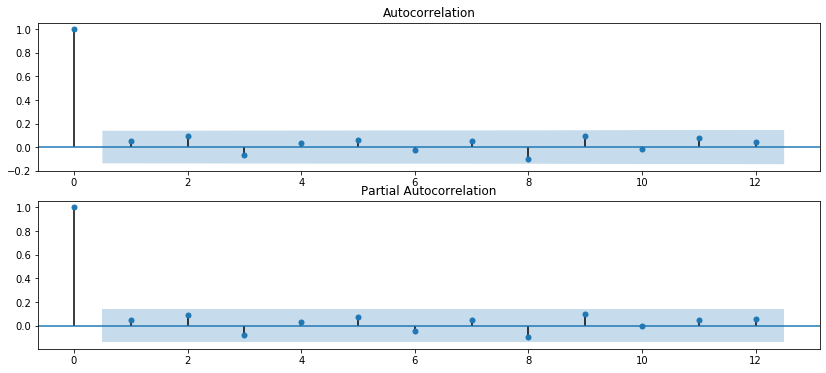

###
### Test de Dickey-Fuller aumentado sobre la serie doble diferencial (Estacionalidad)
###


(-15.325164930646636,
 4.0145765250006756e-28,
 0,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 283.75391790266093)


###
### Gráficos ACF y PACF para verificar la estacionaridad de la serie doble diferencial - Estacionalidad (train)
###


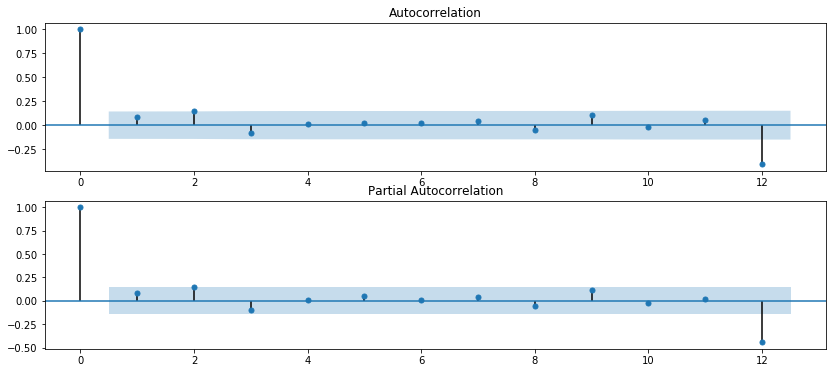

###
### Ruido Blanco
###


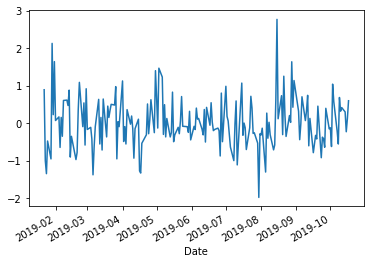

(-5.3980413005541,
 3.419437838007332e-06,
 11,
 176,
 {'1%': -3.4680615871598537,
  '5%': -2.8781061899535128,
  '10%': -2.5756015922004134},
 309.02734778308275)

###
### La serie es estacionaria con error < 1%
###

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=382.050, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=343.871, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=382.771, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=331.678, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=331.448, Time=0.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=344.128, Time=0.20 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.68 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=332.034, Time=0.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=332.541, Time=1.40 sec
 ARI

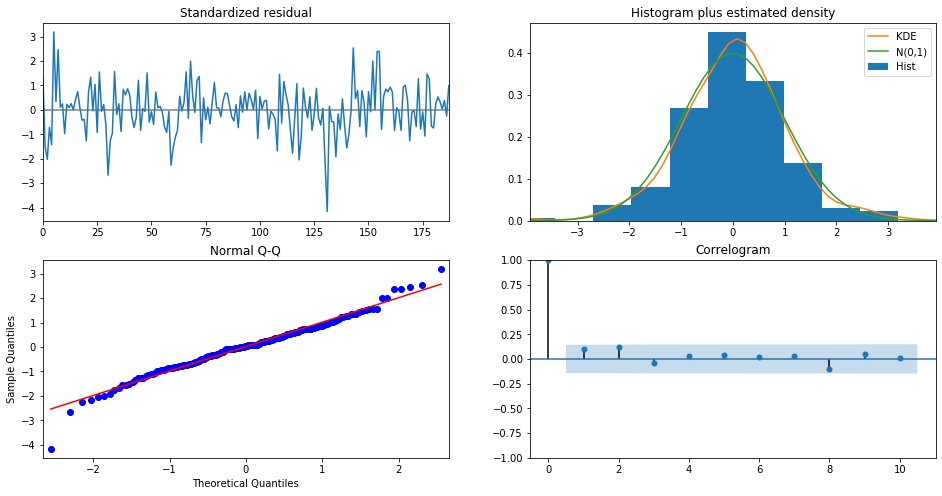

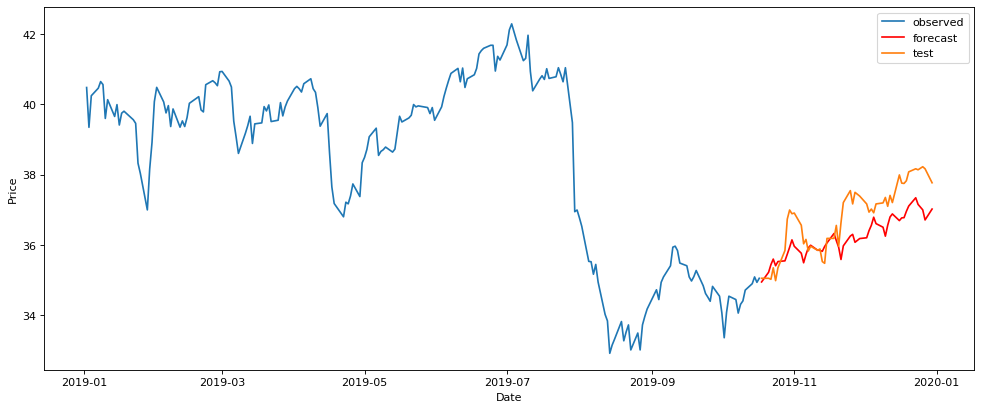

###
### Serializamos el modelo:model_sarima_PFE.pkl
###

###
### Modelo PROPHET
###

(252, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2019-01-02 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      252 non-null    datetime64[ns]
 1   y       252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.9 KB


INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-05 00:00:00 and 2019-11-01 00:00:00



###
### Métricas y Modelo PROPHET pronosticando a 60 días
### PROPHET proporcionará un diagrama de componentes que describe gráficamente el modelo fitteado.
###

   horizon         mse      rmse       mae    mape   mdape  coverage
49 56 days  11317.4956  106.3837   62.3060  1.5087  0.1335       0.0
50 57 days  11430.5496  106.9137   62.5375  1.5140  0.1335       0.0
51 58 days  22288.9208  149.2947   91.8224  2.2021  1.0165       0.0
52 59 days  38377.3593  195.9014  124.4651  2.9636  1.0165       0.0
53 60 days  38013.4238  194.9703  119.8078  2.8513  0.1322       0.0
###
### Serializamos el modelo:model_prophet_PFE.pkl
###


127.0.0.1 - - [28/Oct/2020 22:52:44] "POST /analizar_empresa HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Oct/2020 22:52:44] "POST /analizar_empresa HTTP/1.1" 200 -


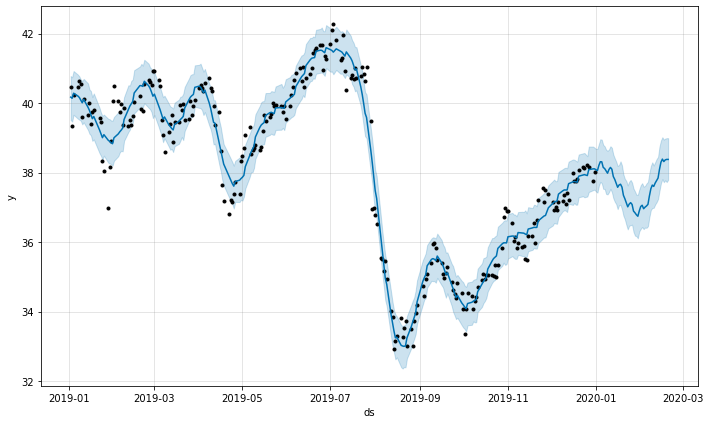

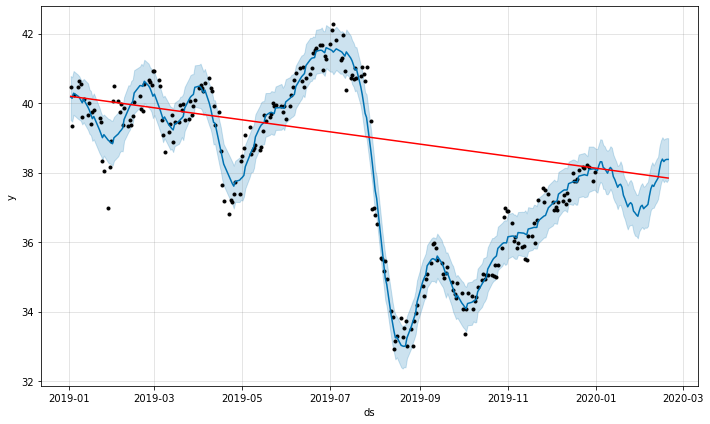

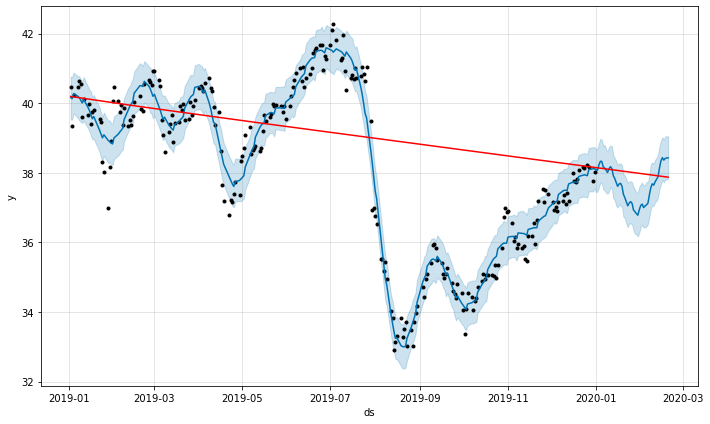

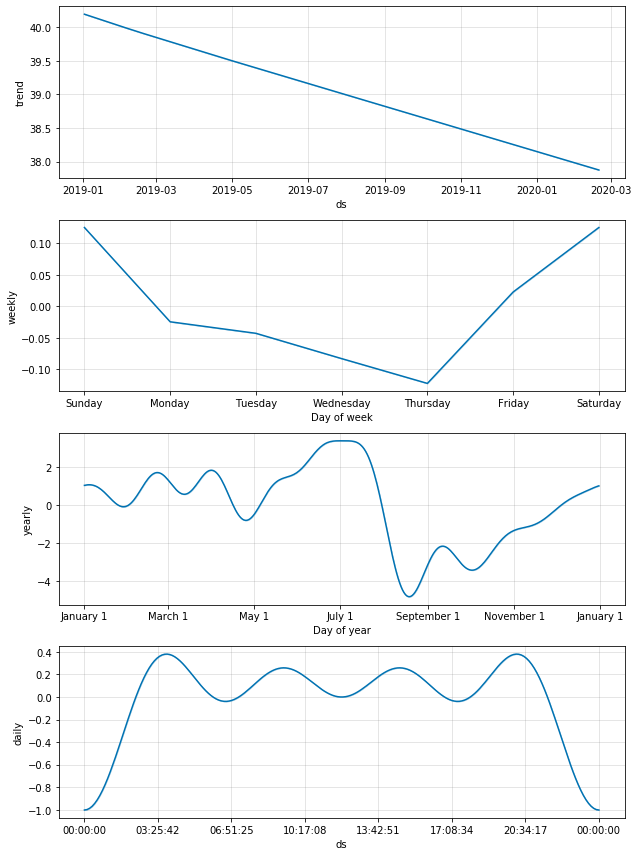

In [4]:
# Ahora ejecutamos esta línea de código que pone a disposición los endpoints que armamos arriba. 
# Es hora de ir a la otra notebook en la que simulamos ser un cliente y hacer los llamadados para cada
# uno de estos endpoints...
app.run(host='0.0.0.0')

In [ ]:
#plot_serie_empresa('PFE', '2019-01-01', '2019-12-31')